# Imports

## Libraries

In [1]:
import sys
import time
import math
import itertools



import numpy as np
import pandas as pd



import matplotlib.pyplot as plt


from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist
from sklearn.preprocessing import normalize

import torch



import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader

## Data

In [2]:
def get_mnist_data(train, download, save):
    if download:

        transform_to_tensor = transforms.Compose([transforms.ToTensor()])


        dataset = torchvision.datasets.MNIST(
            root="./data", train=train, download=True, transform=transform_to_tensor
        )


        dataloader = DataLoader(dataset, batch_size=len(dataset), shuffle=True)
        dataiter = iter(dataloader)
        images, labels = next(dataiter)

        images = images.view(images.size(0), -1)  # (batch_size, 28*28)

        images_np = images.numpy()
        labels_np = labels.numpy()
        if save:
            if train:
                np.save("mnist_train.npy", images_np)
                np.save("mnist_train_labels.npy", labels_np)
            else:
                np.save("mnist_test.npy", images_np)
                np.save("mnist_test_labels.npy", labels_np)
    else:
        if train:
            images_np = np.load("mnist_train.npy")
            labels_np = np.load("mnist_train_labels.npy")
        else:
            images_np = np.load("mnist_test.npy")
            labels_np = np.load("mnist_test_labels.npy")

    return images_np, labels_np

In [3]:
images, labels = get_mnist_data(train=True, download=False, save=False)
print(images.shape, labels.shape)

(60000, 784) (60000,)


In [4]:
images_test, labels_test = get_mnist_data(train=False, download=False, save=False)
print(images_test.shape, labels_test.shape)

(10000, 784) (10000,)


## Data processing

In [5]:
pca = PCA(n_components=164, svd_solver="full")  # Specify 164 components
images_pca = pca.fit_transform(images)
images_pca_test = pca.transform(images_test)

In [6]:
images_pca_normalized = normalize(images_pca, norm="l2", axis=1)
images_pca_test_normalized = normalize(images_pca_test, norm="l2", axis=1)

In [7]:
# images_pca_normalized = images_pca
# images_pca_test_normalized = images_pca_test

In [8]:
print(images_pca_normalized.shape, images_pca_test_normalized.shape)

(60000, 164) (10000, 164)


# Data analysis

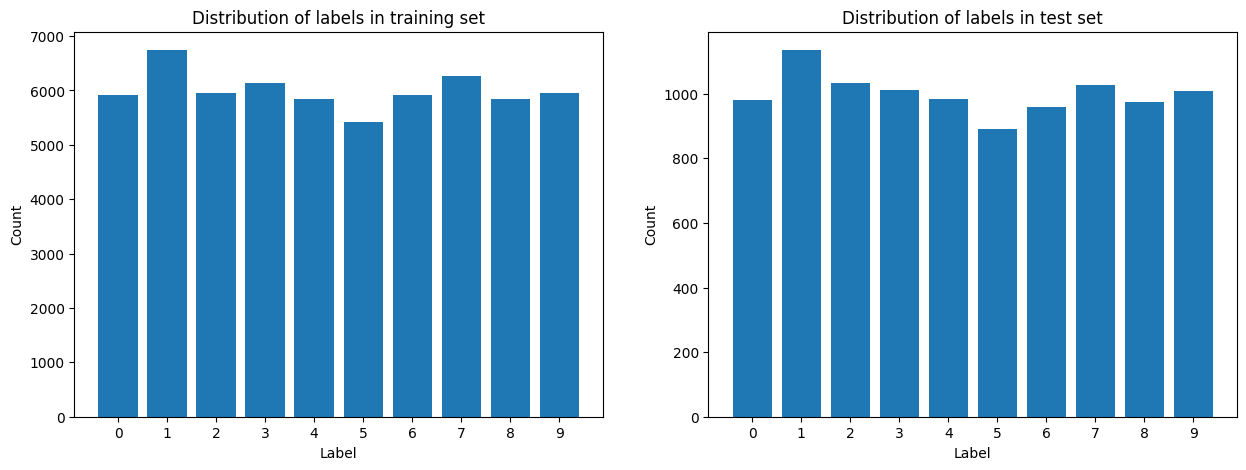

In [9]:
labels_train, counts_train = np.unique(labels, return_counts=True)
labels_test, counts_test = np.unique(labels_test, return_counts=True)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].bar(labels_train, counts_train)
ax[0].set_title("Distribution of labels in training set")
ax[0].set_xlabel("Label")
ax[0].set_ylabel("Count")
ax[0].set_xticks(labels_train)

ax[1].bar(labels_test, counts_test)
ax[1].set_title("Distribution of labels in test set")
ax[1].set_xlabel("Label")
ax[1].set_ylabel("Count")
ax[1].set_xticks(labels_test)

plt.show()

In [10]:
labels

array([2, 6, 1, ..., 5, 9, 0], dtype=int64)

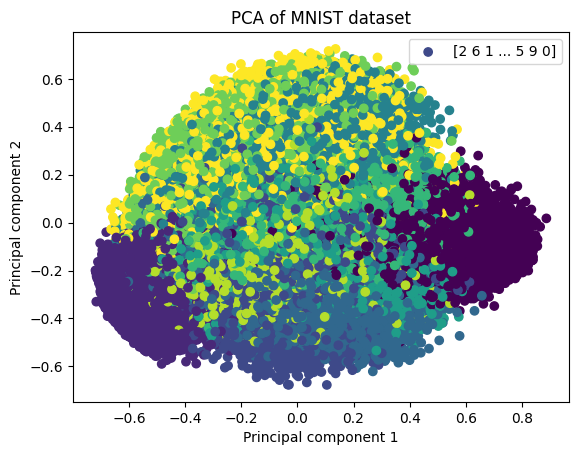

In [11]:
plt.scatter(
    images_pca_normalized[:, 0], images_pca_normalized[:, 1], c=labels, label=labels
)
plt.title("PCA of MNIST dataset")
plt.xlabel("Principal component 1")
plt.ylabel("Principal component 2")
# plt.colorbar()
plt.legend()
plt.show()

# Metric Learning

## Defining functions

In [12]:
def distance_metric(a, b, M):
    a = np.array(a)
    b = np.array(b)

    if a.shape != b.shape:
        raise ValueError("x and x_prime must have the same shape.")

    if M is None:
        raise ValueError("M is None")
        M = np.eye(len(a))
    else:
        if M.shape[0] != M.shape[1]:
            raise ValueError("M must be a square matrix.")
        if M.shape[0] != len(a):
            raise ValueError(
                "M must have the same number of rows/columns as the dimensionality of a and b."
            )

    left = a - b
    right = np.transpose(left)

    return float(left @ M @ right)

In [13]:
def hinge_loss(real_distance, distance_predicted, b):
    if b < 0:
        raise ValueError("b must be greater than or equal to 0.")
    value = real_distance * (b - distance_predicted)
    hinge_loss = max(0, 1 - value)
    return hinge_loss, value

In [14]:
def project_to_psd(M, tol=1e-10):
    # Eigenvalue decomposition of the matrix
    eigvals, eigvecs = np.linalg.eigh(M)

    # Set negative eigenvalues to zero with a tolerance to avoid numerical issues
    eigvals = np.maximum(eigvals, tol)

    # Reconstruct the PSD matrix
    M_psd = np.dot(eigvecs, np.dot(np.diag(eigvals), eigvecs.T))

    # Ensure the matrix is symmetric
    M_psd = (M_psd + M_psd.T) / 2

    return M_psd

In [15]:
def clip_gradient(grad, max_norm):
    norm = np.linalg.norm(grad)
    if norm > max_norm:
        grad = grad * (max_norm / norm)  # Scale the gradient down to the threshold
    return grad

In [43]:
def sgd_metric_learning(
    X_train,
    y_train,
    M,
    learning_rate,
    n_iters,
    batch_size,
    b,
    print_every=10,
    max_patience=5,
):

    n = len(X_train)
    loss_history = []
    grad_history = []
    m_history = [M.copy()]
    pairs = list(itertools.combinations(range(batch_size), 2))
    patience = 0

    for iteration in range(n_iters):
        grad_M = np.zeros((X_train.shape[1], X_train.shape[1]))  # 164x164
        indices = np.random.choice(n, size=batch_size, replace=True)
        X_batch = X_train[indices]
        y_batch = y_train[indices]
        batch_labels, batch_counts = np.unique(y_batch, return_counts=True)

        batch_loss = 0
        for i, j in pairs:
            pred = distance_metric(X_batch[i], X_batch[j], M)
            true_value = 1 if y_batch[i] == y_batch[j] else 0
            loss, value = hinge_loss(true_value, pred, b)
            batch_loss += loss

            if loss > 0:  # equivalent to distance_predicted < b or value < 1
                grad_M += (
                    true_value
                    * np.transpose((X_batch[i] - X_batch[j]))
                    @ (X_batch[i] - X_batch[j])
                )
            # else:
            #     grad_M += np.zeros((X_train.shape[1], X_train.shape[1]))

        grad_M = grad_M / batch_size
        grad_M /= np.linalg.norm(grad_M)
        grad_history.append(np.linalg.norm(grad_M))

        batch_loss /= batch_size
        loss_history.append(batch_loss)

        M -= learning_rate * grad_M
        m_history.append(M)

        # Project M back to the positive semi-definite cone
        M = project_to_psd(M)

        # Print loss at every iteration
        if iteration % print_every == 0:
            print(f"Iteration {iteration}/{n_iters}, Loss: {batch_loss}")

            # Check if loss is not decreasing
            if iteration > 0:
                if loss_history[iteration] > loss_history[iteration - 1]:
                    patience += 1

                    # Early stopping if the loss has not decreased for a while
                    if patience >= max_patience:
                        print(
                            f"Early stopping since loss has not decreased in {patience*print_every} steps."
                        )
                        break
                else:
                    patience = 0

    return M, loss_history, grad_history, m_history

In [44]:
def check_batch_size(wanted_batch_size):
    number_individual_observation = (1 + math.sqrt(1 + 8 * wanted_batch_size)) / 2
    if number_individual_observation.is_integer():
        good_batch_size = int(number_individual_observation)
    else:
        raise ValueError("Batch size must be a triangular number.")
    return good_batch_size

## Set hyperparameters

In [45]:
M = np.random.rand(images_pca_normalized.shape[1], images_pca_normalized.shape[1])
learning_rate = 0.001
b = 2
n_iters = 5000
final_batch_size = 253
initial_batch_size = check_batch_size(final_batch_size)
print(initial_batch_size)

23


Iteration 0/5000, Loss: 10.362205995795636
Iteration 100/5000, Loss: 12.32241300059912
Iteration 200/5000, Loss: 12.079380973729815
Iteration 300/5000, Loss: 12.140668743936653
Iteration 400/5000, Loss: 12.36795100043883
Iteration 500/5000, Loss: 13.22783939534728
Iteration 600/5000, Loss: 12.535859901659075
Iteration 700/5000, Loss: 11.893512368604013
Iteration 800/5000, Loss: 12.559532189426472
Iteration 900/5000, Loss: 11.658880344814879
Iteration 1000/5000, Loss: 11.902577652015104
Iteration 1100/5000, Loss: 11.541082556448911
Iteration 1200/5000, Loss: 11.437428474872029
Iteration 1300/5000, Loss: 11.923914111534316
Iteration 1400/5000, Loss: 12.908111538081691
Iteration 1500/5000, Loss: 13.02566540743793
Iteration 1600/5000, Loss: 12.54203690350747
Iteration 1700/5000, Loss: 12.464908672645922
Iteration 1800/5000, Loss: 12.82023025574226
Early stopping since loss has not decreased in 500 steps.
Time taken: 90.36691856384277 seconds


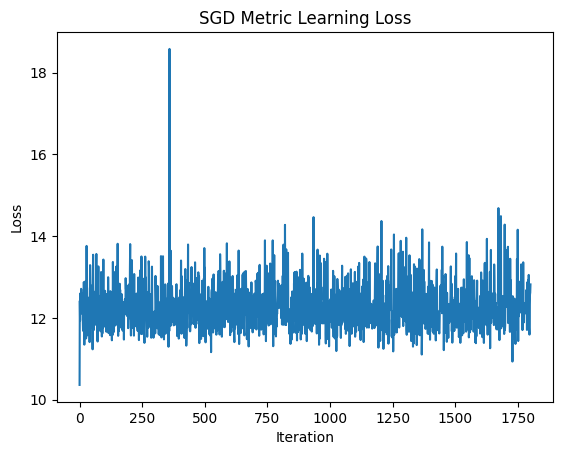

In [46]:
start = time.time()
M_learned, loss_history, grad_history, m_history = sgd_metric_learning(
    images_pca_normalized,
    labels,
    M,
    learning_rate,
    n_iters,
    initial_batch_size,
    b,
    print_every=100,
)
end = time.time()
print(f"Time taken: {end - start} seconds")

# Plot the loss over iterations
plt.plot(loss_history)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("SGD Metric Learning Loss")
plt.show()

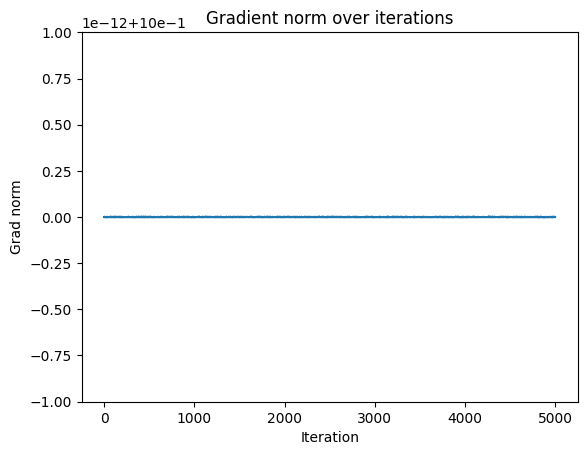

In [21]:
plt.plot(grad_history)
plt.xlabel("Iteration")
plt.ylabel("Grad norm")
plt.title("Gradient norm over iterations")
plt.show()

In [22]:
len(m_history)

5001

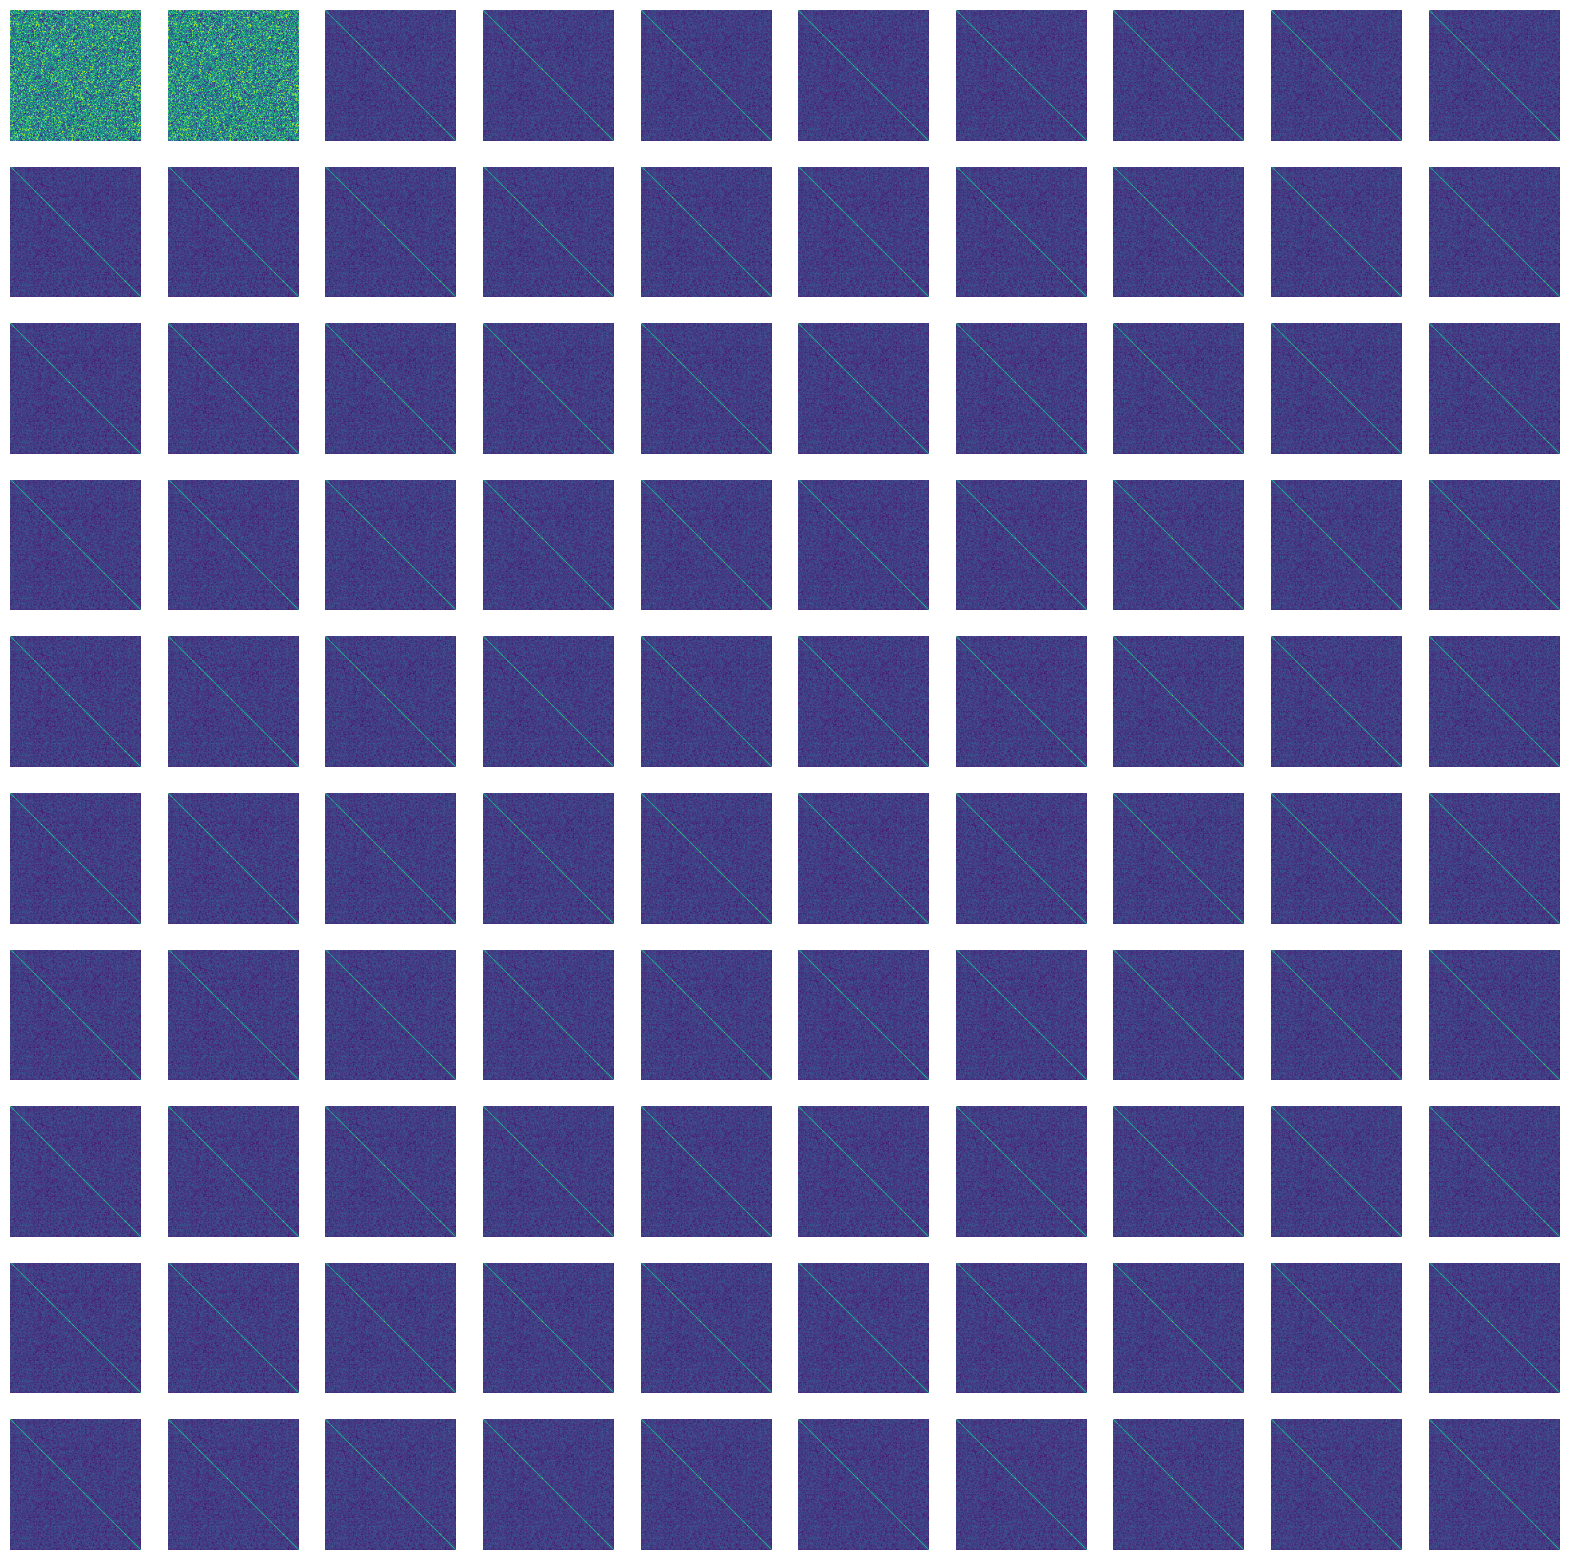

In [23]:
fig, ax = plt.subplots(len(m_history[:100]) // 10, 10, figsize=(20, 20))

for i, m in enumerate(m_history[:100]):  # Limit to the first 100 items
    ax[i // 10, i % 10].imshow(m)
    ax[i // 10, i % 10].axis("off")

plt.show()